In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from IPython.display import clear_output

HOME = os.getcwd()
DIR = '/kaggle/input'
print('HOME:', HOME, DIR)

HOME: /kaggle/working /kaggle/input


In [2]:
!pip install ultralytics
!pip install motmetrics
!git clone https://github.com/facebookresearch/segment-anything-2.git

%cd segment-anything-2 & pip install -e .

%cd {HOME}/segment-anything-2/checkpoints/
!wget -P {HOME}/segment-anything-2/checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
%cd {HOME}
!pip install hydra-core --upgrade

!yes | cp -r {DIR}/sam2-camera-predictor/. {HOME}/segment-anything-2/sam2

clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.95 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


In [3]:
import sys
from pathlib import Path
from collections import defaultdict
from time import time as t
from datetime import timedelta
import json
import gc
import torch
from torch import nn
import torchvision
from ultralytics import YOLO, SAM
sys.path.append('/kaggle/working/segment-anything-2')
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor, build_sam2, build_sam2_camera_predictor
import motmetrics as mm
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.autocast('cuda', dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)   
set_seed()

DEBUG = True

In [4]:
path_model = f'{DIR}/trackingdatapart3/'
checkpoint_file = path_model + 'yolov10x_v2_4_best.pt'
video_path = f'{DIR}/notebookc564e1fafe/renue_video.mp4'

gt = np.loadtxt(f'{DIR}/trackingdatapart1/Datasets/Datasets/mot_dataset/gt/gt.txt', delimiter=',')

In [5]:
def show_track_for_segmentation(frame, bboxs, obj_id, masks, time=None):
    
    color_map = {i: tuple(map(lambda x: x*255, sns.color_palette('pastel', 14)[-(i+1)])) for i in range(14)}
    for box, track_id in zip(bboxs, obj_id):
        x, y, w, h = box
        track = track_history[track_id]
        track.append((float(x+(w-x)/2), float(y+(h-y)/2)))
        cls = labels_tracks[track_id]
        if len(track) > 30:  
            track.pop(0)
        points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
        
        cv2.polylines(frame, [points], isClosed=False, color=(230, 230, 230), thickness=12)
        cv2.rectangle(frame, (int(x), int(y)), (int(w), int(h)), color_map[int(cls)], 8)
        cv2.putText(frame, f'id:{str(track_id)} class:{str(int(cls))}', (int(x) + 20, int(y) - 40), cv2.FONT_HERSHEY_SIMPLEX, 2, color=(230, 230, 230), thickness=8)
        
    cv2.putText(frame, f'processing time:{time:.2f} msec', (width-800, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=(200, 50, 50), thickness=6)
    plt.imshow(frame)
    
    for mask, track_id in zip(masks, obj_id):
        show_mask(mask, plt.gca(), obj_id=track_id)

    return track_history

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    ax.imshow(mask_image)

In [7]:
def bbox_iou_np(boxes1, boxes2):
    x1 = np.maximum(boxes1[:, None, 0], boxes2[:, 0])
    y1 = np.maximum(boxes1[:, None, 1], boxes2[:, 1])
    x2 = np.minimum(boxes1[:, None, 2], boxes2[:, 2])
    y2 = np.minimum(boxes1[:, None, 3], boxes2[:, 3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)

    box1_area = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    box2_area = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    iou = inter_area / (box1_area[:, None] + box2_area - inter_area)

    return iou

In [8]:
def get_info_frame_sam2(box, track_id):
    results_frame = {'rf': []}
    for box, track_id in zip(bboxs, obj_id):
        x, y, w, h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        results_frame['rf'].append({
                'bbox': [x, y, w, h], 
                'track_id': track_id, 
                'class': int(labels_tracks[track_id])
            })
    return results_frame    

## Video segmentation real time with SAM 2

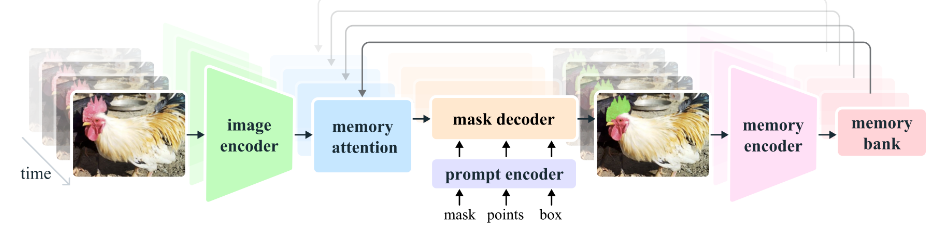

С дополнением для обработки видео в режиме реального времени: https://github.com/Gy920/segment-anything-2-real-time/tree/main

In [9]:
detector = YOLO(checkpoint_file)
sam2_checkpoint = '/kaggle/input/sam2-hiera-tiny/sam2_hiera_tiny.pt'
model_cfg = 'sam2_hiera_t.yaml'
predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [10]:
def get_non_empty_masks(out_mask_logits, out_obj_ids, show=False):
    
    filter_ = ((out_mask_logits > 0.0)== False).all(dim=(1,2,3))
    ind_ = torch.nonzero(filter_).cpu().squeeze(1).tolist() 
    bboxs_sam = torchvision.ops.masks_to_boxes((out_mask_logits>0.0)[~filter_].cpu().squeeze(1)).numpy().astype('int32')
    bboxs, obj_id = bboxs_sam.tolist().copy(), out_obj_ids.copy() #пришёл
    if len(ind_)>0: #пришёл, ушёл
        obj_id = [obj_id[i] for i in range(len(obj_id)) if i not in ind_]
    if show:
        masks = (out_mask_logits>0.0)[~filter_].cpu().numpy()
        return bboxs_sam, bboxs, obj_id, masks
    return bboxs_sam, bboxs, obj_id

In [11]:
def new_start_segmentation(res_det, frame, track_counter, labels_tracks, out_obj_ids=None, out_mask_logits=None):
    
    indices = []
    if out_obj_ids is None:
        bboxs, labels = res_det[0].boxes.xyxy.cpu().tolist(), res_det[0].boxes.cls.cpu().tolist()
        obj_id = [i for i in range(1, len(labels)+1)]
        track_counter = len(labels)+1
        labels_tracks = {obj_id[i]: labels[i] for i in range(0, len(obj_id))}
            
    else:
        bboxs_detector = res_det[0].boxes.xyxy.cpu().numpy().astype('int32')
        labels_ = res_det[0].boxes.cls.cpu().tolist()
        bboxs_sam, bboxs, obj_id = get_non_empty_masks(out_mask_logits, out_obj_ids)
        iou = bbox_iou_np(bboxs_detector, bboxs_sam)
        indices.extend(np.argwhere(((iou> 0) & (iou <= 0.25)))[:, 0].tolist()) #близкие
        if len(np.argwhere(np.all(iou==0, axis=1)))>0:
            indices.extend(np.argwhere(np.all(iou==0, axis=1)).tolist()[0]) #далекие

        for i_ in indices:
            bboxs.append(bboxs_detector[i_].tolist())
            obj_id.append(track_counter)
            labels_tracks[track_counter]=labels_[i_]
            track_counter+=1 
        predictor.reset_state()
    
    predictor.load_first_frame(frame)
    for i in range(len(bboxs)):
        ann_obj_id = (obj_id[i])
        bbox = [bboxs[i][:2], bboxs[i][2:]]
        _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(frame_idx=0, obj_id=ann_obj_id, bbox=bbox)

    return out_obj_ids, out_mask_logits, predictor, track_counter, labels_tracks

In [12]:
track_counter = 0
start_frame_idx = 0
last_frame = 10
track_history = defaultdict(lambda: [])
resuls_tracking = {'results': []}
labels_tracks = {}

cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

In [13]:
start = t()
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_idx)
_, frame = cap.read()
res_det = detector(frame, iou=0.5, verbose=False)
predictor.load_first_frame(frame)

out_obj_ids, out_mask_logits, predictor, track_counter, labels_tracks = new_start_segmentation(res_det, frame, track_counter, labels_tracks)
_, bboxs, obj_id = get_non_empty_masks(out_mask_logits, out_obj_ids)
stop = t()
processing_time = (timedelta(seconds=stop-start).total_seconds())*1000
results_frame = get_info_frame_sam2(bboxs, obj_id)
resuls_tracking['results'].append({
                    'tracker': 'sam2',
                    'frame': start_frame_idx+1,
                    'time': processing_time,
                    'results_frame': results_frame['rf']
})


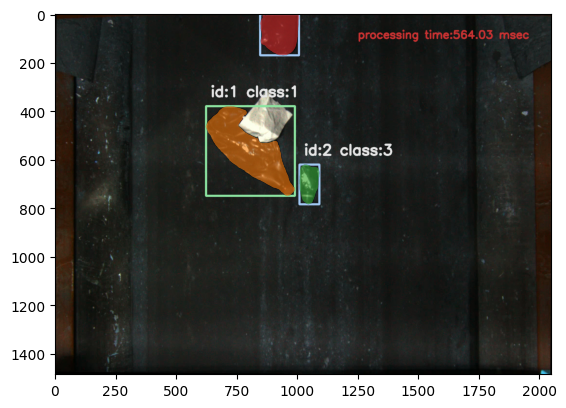

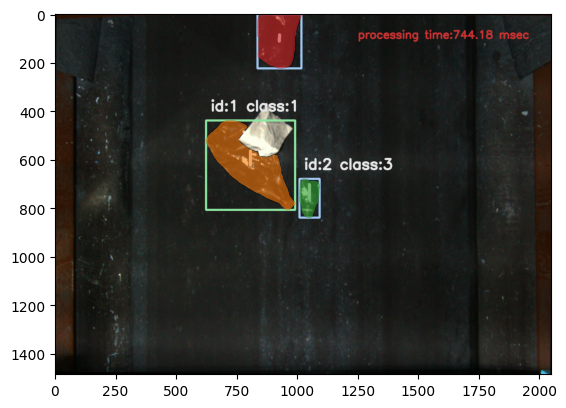

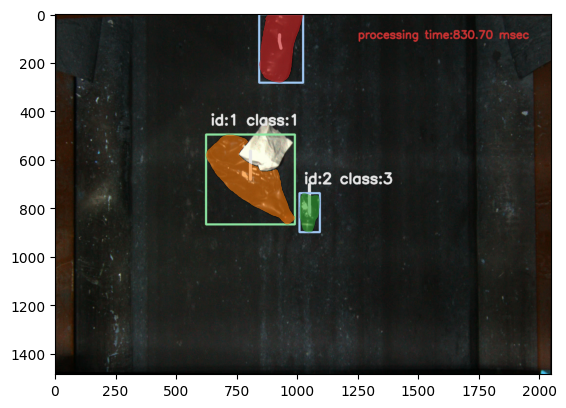

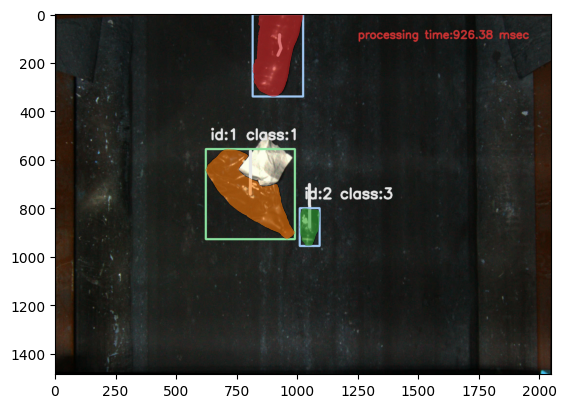

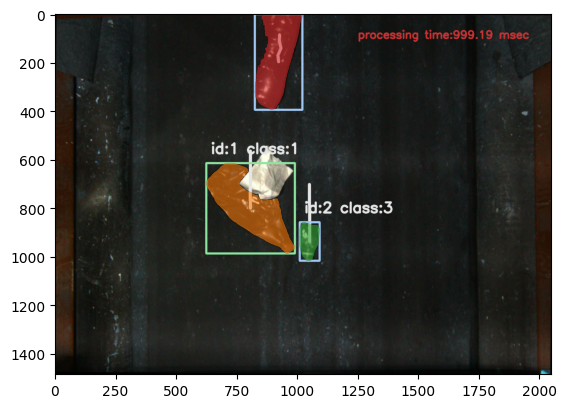

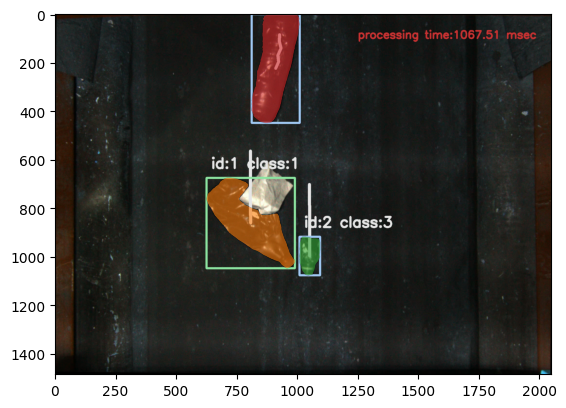

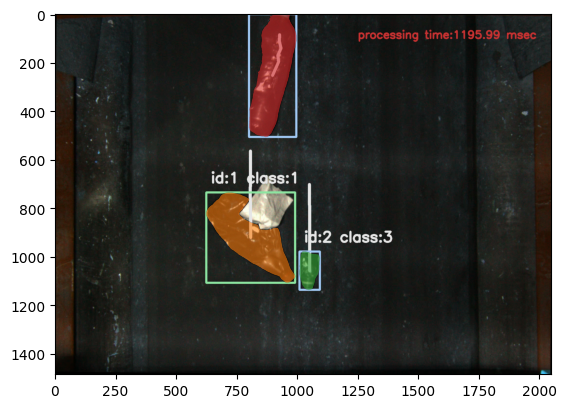

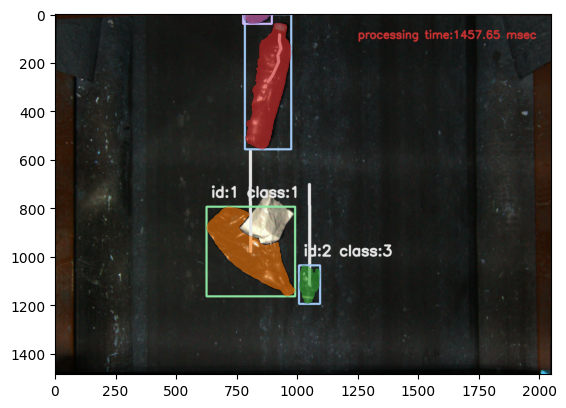

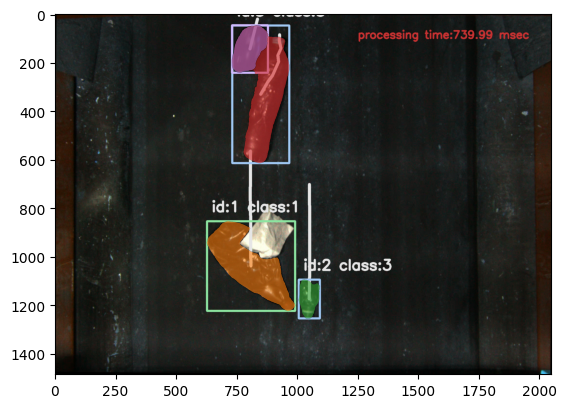

In [14]:
for ann_frame_idx in range(start_frame_idx+1, 10):
    start = t()
    _, frame = cap.read()
    res_det = detector(frame, iou=0.5, verbose=False)
    out_obj_ids, out_mask_logits = predictor.track(frame)
    
    filter_ = ((out_mask_logits > 0.0)== False).all(dim=(1,2,3)) #np.all((out_mask_logits > 0.0).cpu().numpy() == False, axis = (1,2,3))
    if len(res_det[0].boxes.cls.cpu().tolist())>len((out_mask_logits>0.0)[~filter_]):
        out_obj_ids, out_mask_logits, predictor, track_counter, labels_tracks = new_start_segmentation(res_det, frame, track_counter, labels_tracks, out_obj_ids, out_mask_logits)
    
    _, bboxs, obj_id = get_non_empty_masks(out_mask_logits, out_obj_ids)
    stop = t()
    processing_time = (timedelta(seconds=stop-start).total_seconds())*1000
    results_frame = get_info_frame_sam2(bboxs, obj_id)
    if  DEBUG and ann_frame_idx>=last_frame-10:
        _, bboxs, obj_id, masks = get_non_empty_masks(out_mask_logits, out_obj_ids, show=True)
        show_track_for_segmentation(frame, bboxs, obj_id, masks, processing_time)
        plt.show()
    
    resuls_tracking['results'].append({
                    'tracker': 'sam2',
                    'frame': ann_frame_idx+1,
                    'time': processing_time,
                    'results_frame': results_frame['rf']
            })

In [15]:
def get_metrics_tracker_in_detail(gt, tg, fr_min, fr_max, max_iou=1):
    acc = mm.MOTAccumulator(auto_id=True)
    for frame in range(fr_min, fr_max+1):
        gt_dets = gt[gt[:,0]==frame,1:6] 
        t_dets = tg[tg[:,0]==frame,1:6]
        C = mm.distances.iou_matrix(gt_dets[:,1:], t_dets[:,1:], max_iou=max_iou)
        acc.update(gt_dets[:,0].astype('int').tolist(), t_dets[:,0].astype('int').tolist(), C)
            
    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=['num_frames', 'idf1', 'idp', 'idr', \
                                     'recall', 'precision', 'num_objects', \
                                     'mostly_tracked', 'partially_tracked', \
                                     'mostly_lost', 'num_false_positives', \
                                     'num_misses', 'num_switches', \
                                     'num_fragmentations', 'mota', 'motp' \
                                    ], name='acc')
    return summary, acc

def get_tg_info(row):
    x, y, w, h = row['bbox']
    return x, y, w, h 

In [16]:
result = pd.json_normalize(resuls_tracking['results'], 'results_frame', ['tracker', 'frame', 'time'])
result[['x', 'y', 'w', 'h']] = result.apply(get_tg_info, axis = 1, result_type='expand')
result.head(2)

,bbox,track_id,class,tracker,frame,time,x,y,w,h
0,"[620, 322, 368, 367]",1,1,sam2,1,2672.355,620,322,368,367
1,"[1003, 563, 84, 159]",2,3,sam2,1,2672.355,1003,563,84,159


In [17]:
results_metrics = []

for tracker in result.tracker.unique():
    fr_min = result.loc[result.tracker==tracker]['frame'].min()
    fr_max = result.loc[result.tracker==tracker]['frame'].max()
    tg = result.loc[result.tracker==tracker][['frame', 'track_id', 'x', 'y', 'w', 'h']].to_numpy()
    summary, _ = get_metrics_tracker_in_detail(gt, tg, fr_min, fr_max)
    
    results_metrics.append([tracker, summary['num_frames'][0], summary['idf1'][0], summary['idp'][0], summary['idr'][0],\
                            summary['recall'][0], summary['precision'][0], summary['num_objects'][0], summary['mostly_tracked'][0],\
                            summary['partially_tracked'][0], summary['mostly_lost'][0], summary['num_false_positives'][0], summary['num_misses'][0],\
                            summary['num_switches'][0], summary['num_fragmentations'][0], summary['mota'][0], summary['motp'][0]])
    

In [18]:
pd.DataFrame(results_metrics, columns = ['tracker', 'num_frames', 'idf1', 'idp', 'idr', 'recall', 'precision',
      'num_objects', 'mostly_tracked', 'partially_tracked', 'mostly_lost',
      'num_false_positives', 'num_misses', 'num_switches',
      'num_fragmentations', 'mota', 'motp'])

,tracker,num_frames,idf1,idp,idr,recall,precision,num_objects,mostly_tracked,partially_tracked,mostly_lost,num_false_positives,num_misses,num_switches,num_fragmentations,mota,motp
0,sam2,10,1.0,1.0,1.0,1.0,1.0,32,4,0,0,0,0,0,0,1.0,0.170621
